## BT4211 Group 9 Hotel Project 

### Jupyter Notebook to: 
- ML Regression Task to predict Total Revenue
    - $\frac{Confirmed+NoShow}{Total Bookings} \rightarrow$ RATIO

$(Lodging Revenue Per Room + Other Revenue Per Room) \times RATIO = Total Revenue Per Room$

### Project Setup 

In [882]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import tree
from sklearn.tree import plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import linear_model
from dython.nominal import associations
import matplotlib.pyplot as plt

In [883]:
np.random.seed(4211)

In [884]:
# Read in cleaned dataset 
hotel_df = pd.read_csv("HotelCustomersDataset_Cleaned.csv")
hotel_df.drop("Unnamed: 0", axis=1, inplace= True) # Drop the weird 1st index column
hotel_df

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,DistributionChannel_Direct,DistributionChannel_Electronic Distribution,DistributionChannel_Travel Agent/Operator,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Other,MarketSegment_Travel Agent/Operator
0,1,PRT,51.0,150,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,45,371.0,105.3,1,...,0,0,0,0,0,1,0,0,0,0
1,3,DEU,31.0,1095,0x31C5E4B74E23231295FDB724AD578C02C4A723F4BA2B...,0xC7CF344F5B03295037595B1337AC905CA188F1B5B3A5...,0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,0,1
2,4,FRA,60.0,1095,0xFF534C83C0EF23D1CE516BC80A65D0197003D27937D4...,0xBD3823A9B4EC35D6CAF4B27AE423A677C0200DB61E82...,93,240.0,60.0,0,...,0,0,1,0,0,0,0,0,0,1
3,5,FRA,51.0,1095,0x9C1DEF02C9BE242842C1C1ABF2C5AA249A1EEB4763B4...,0xE175754CF77247B202DD0820F49407C762C14A603B3A...,0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,0,1
4,6,JPN,54.0,1095,0x6E70C1504EB27252542F58E4D3C8C83516E093334721...,0xE82EC1D6938A04CF19E1F7F55A402E7ABC686261537A...,58,230.0,24.0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75392,83585,ITA,52.0,0,0xC93C23F50B11F71BD77EC36202B9D42AB0BAA8E77F9F...,0x7AE14552CC1ABDB74EED8F709E9ECDDA822F164C704F...,116,336.9,105.5,0,...,0,0,1,0,0,0,0,0,1,0
75393,83586,ITA,54.0,0,0x68010434A46BA6CEAFFACF00B7B7CD0E1825DC56E68F...,0x0A4038E9AE1E4E5A14832BEACEC6BCBE2219F275B65C...,0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,1,0
75394,83587,IRL,47.0,0,0x6DE7954E6AF065D29EF5C57D0DC8120FBAE6753D2CCB...,0xC0654B6A53840DD95DAE429966EC16E2A11FB186CC7B...,109,327.1,277.5,0,...,0,0,1,0,0,0,0,0,1,0
75395,83588,IRL,53.0,0,0x533C977BA6D1D8DFAD8D8D4C2250236D16EFD17B9F35...,0x3DCBEB254247836015CA95F0BBF42E6AF6A158380663...,0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,1,0


In [885]:
hotel_df.dtypes

ID                                               int64
Nationality                                     object
Age                                            float64
DaysSinceCreation                                int64
NameHash                                        object
DocIDHash                                       object
AverageLeadTime                                  int64
LodgingRevenue                                 float64
OtherRevenue                                   float64
BookingsCanceled                                 int64
BookingsNoShowed                                 int64
BookingsCheckedIn                                int64
PersonsNights                                    int64
RoomNights                                       int64
DaysSinceLastStay                                int64
DaysSinceFirstStay                               int64
SRHighFloor                                      int64
SRLowFloor                                       int64
SRAccessib

### Further Pre-processing

In [886]:
# Drop the ID, Nationality, Name Hash and DocID Hash 
hotel_df.drop(columns = ["ID", "Nationality", "NameHash", "DocIDHash"], inplace = True)

In [887]:
# Creating the Ratio Metric needed as one of our dependent variable
hotel_df["Ratio"] = (hotel_df["BookingsCheckedIn"] + hotel_df["BookingsNoShowed"]) / \
    (hotel_df["BookingsCheckedIn"] + hotel_df["BookingsNoShowed"] + hotel_df["BookingsCanceled"])

# Drop rows for guests i.e. days since last and first stay are -1 but there's room information
# Find columns which describe attributes of rooms and create a col to chk if any of them have been made
room_chars_cols = [col for col in hotel_df.columns.tolist() if col.startswith('SR')]
hotel_df['room_chars_sum'] = hotel_df.loc[:,room_chars_cols].sum(axis=1)

#filter df to get only guests
def filter(df, **kwargs):
    query_list = []
    for key in kwargs.keys():
        if key.startswith('room'):
            query_list.append(f'{key}!={kwargs[key]}')
        else:
            query_list.append(f'{key}=={kwargs[key]}')
    query = ' & '.join(query_list)
    return df.query(query)
guest_df_to_drop = filter(hotel_df, room_chars_sum = 0, DaysSinceLastStay = -1, DaysSinceFirstStay = -1)
guest_idx_to_drop = guest_df_to_drop.index.to_list()

#drop guests from df
hotel_df_no_guests =  hotel_df.drop(guest_idx_to_drop)

hotel_df_no_guests['Ratio'].isna().sum() # 6189
hotel_df_no_guests['DaysSinceLastStay'].eq(-1).sum() #6190 this one dude cancelled 2 bookings and had thus ratio of 0 = 0/2
hotel_df_no_guests['Ratio'].eq(0).sum() # 1 just one instance of this happening

# impute guests with nan ratio with 1 as we assume they wouldn't cancel
hotel_df_no_guests['Ratio'] = hotel_df_no_guests['Ratio'].fillna(1)
hotel_df_hasbooked = hotel_df_no_guests #Change name later
hotel_df_hasbooked

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,...,DistributionChannel_Travel Agent/Operator,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Other,MarketSegment_Travel Agent/Operator,Ratio,room_chars_sum
0,51.0,150,45,371.0,105.3,1,0,3,8,5,...,0,0,0,1,0,0,0,0,0.75,0
1,31.0,1095,0,0.0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1.00,0
2,60.0,1095,93,240.0,60.0,0,0,1,10,5,...,1,0,0,0,0,0,0,1,1.00,0
3,51.0,1095,0,0.0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1.00,0
4,54.0,1095,58,230.0,24.0,0,0,1,4,2,...,1,0,0,0,0,0,1,0,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75390,49.0,0,91,143.0,2.0,0,0,1,2,1,...,1,0,0,0,0,0,1,0,1.00,1
75392,52.0,0,116,336.9,105.5,0,0,1,8,4,...,1,0,0,0,0,0,1,0,1.00,0
75393,54.0,0,0,0.0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1.00,0
75394,47.0,0,109,327.1,277.5,0,0,1,6,3,...,1,0,0,0,0,0,1,0,1.00,1


In [888]:
# Creating average revenue metrics 

# Create Average Lodging Revenue
hotel_df_hasbooked["AverageLodgingRevenue"] = hotel_df_hasbooked["LodgingRevenue"] / \
    ((hotel_df_hasbooked["BookingsCheckedIn"] +
     hotel_df_hasbooked["BookingsNoShowed"]))

# Create Average Other Revenue
hotel_df_hasbooked["AverageOtherRevenue"] = hotel_df_hasbooked["OtherRevenue"] / \
    ((hotel_df_hasbooked["BookingsCheckedIn"] +
     hotel_df_hasbooked["BookingsNoShowed"]))

# Create Average Total Revenue
hotel_df_hasbooked["TotalRevenuePerRoom"] = (
    hotel_df_hasbooked["AverageLodgingRevenue"] + hotel_df_hasbooked["AverageOtherRevenue"]) * hotel_df_hasbooked["Ratio"]

# Remove the average lodging revenue and average other revenue as we cannot use these metrics to predict (collinearity) 
hotel_df_hasbooked.drop(
    columns=["AverageLodgingRevenue", "AverageOtherRevenue"], axis=1, inplace=True)

# Remove those with average lodging revenue as 0
hotel_df_hasbooked = hotel_df_hasbooked[hotel_df_hasbooked["TotalRevenuePerRoom"] > 0]


In [889]:
# Normalisation of the appropriate numeric columns 
scaled_columns = ["Age", "DaysSinceCreation", "AverageLeadTime", "LodgingRevenue",
                  "OtherRevenue", "Ratio", "PersonsNights", "RoomNights", "DaysSinceLastStay", "DaysSinceFirstStay"]

# Scale using Sklearn Normalizer
hotel_df_hasbooked_norm = hotel_df_hasbooked.copy()
scaler = preprocessing.Normalizer()
hotel_df_hasbooked_norm[scaled_columns] = scaler.fit_transform(
    hotel_df_hasbooked_norm[scaled_columns])
hotel_df_hasbooked_norm

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,...,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Other,MarketSegment_Travel Agent/Operator,Ratio,room_chars_sum,TotalRevenuePerRoom
0,0.043858,0.128993,0.038698,0.319044,0.090553,1,0,3,0.006880,0.004300,...,0,0,1,0,0,0,0,0.000645,0,119.075
2,0.031224,0.569834,0.048397,0.124895,0.031224,0,0,1,0.005204,0.002602,...,0,0,0,0,0,0,1,0.000520,0,300.000
4,0.028205,0.571927,0.030294,0.120131,0.012535,0,0,1,0.002089,0.001045,...,0,0,0,0,0,1,0,0.000522,0,254.000
6,0.016169,0.553293,0.019201,0.270330,0.047497,0,0,1,0.005053,0.002526,...,0,0,0,0,0,1,0,0.000505,1,629.000
8,0.013076,0.572745,0.050213,0.091011,0.036091,0,0,1,0.003138,0.001569,...,0,0,0,0,0,0,1,0.000523,0,243.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75388,0.204084,0.000000,0.085035,0.748306,0.625006,0,0,1,0.017007,0.008503,...,0,0,0,0,0,1,0,0.004252,0,323.000
75390,0.277662,0.000000,0.515657,0.810319,0.011333,0,0,1,0.011333,0.005667,...,0,0,0,0,0,1,0,0.005667,1,145.000
75392,0.138529,0.000000,0.309026,0.897507,0.281054,0,0,1,0.021312,0.010656,...,0,0,0,0,0,1,0,0.002664,0,442.400
75394,0.105583,0.000000,0.244864,0.734816,0.623391,0,0,1,0.013479,0.006739,...,0,0,0,0,0,1,0,0.002246,1,604.600


<AxesSubplot:>

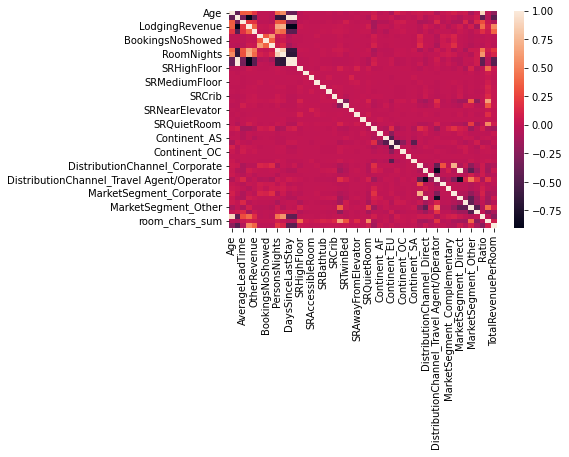

In [890]:
# Create corr heatmap 
corr = hotel_df_hasbooked_norm.corr()
sns.heatmap(corr)

### Remove Random Sample of 100 to mimic the 100 new customers 

In [891]:
newcust_df = hotel_df_hasbooked_norm.sample(100)
hotel_df_hasbooked_norm.drop(newcust_df.index, inplace=True)
hotel_df_hasbooked_norm

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,...,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Other,MarketSegment_Travel Agent/Operator,Ratio,room_chars_sum,TotalRevenuePerRoom
0,0.043858,0.128993,0.038698,0.319044,0.090553,1,0,3,0.006880,0.004300,...,0,0,1,0,0,0,0,0.000645,0,119.075
2,0.031224,0.569834,0.048397,0.124895,0.031224,0,0,1,0.005204,0.002602,...,0,0,0,0,0,0,1,0.000520,0,300.000
4,0.028205,0.571927,0.030294,0.120131,0.012535,0,0,1,0.002089,0.001045,...,0,0,0,0,0,1,0,0.000522,0,254.000
6,0.016169,0.553293,0.019201,0.270330,0.047497,0,0,1,0.005053,0.002526,...,0,0,0,0,0,1,0,0.000505,1,629.000
8,0.013076,0.572745,0.050213,0.091011,0.036091,0,0,1,0.003138,0.001569,...,0,0,0,0,0,0,1,0.000523,0,243.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75388,0.204084,0.000000,0.085035,0.748306,0.625006,0,0,1,0.017007,0.008503,...,0,0,0,0,0,1,0,0.004252,0,323.000
75390,0.277662,0.000000,0.515657,0.810319,0.011333,0,0,1,0.011333,0.005667,...,0,0,0,0,0,1,0,0.005667,1,145.000
75392,0.138529,0.000000,0.309026,0.897507,0.281054,0,0,1,0.021312,0.010656,...,0,0,0,0,0,1,0,0.002664,0,442.400
75394,0.105583,0.000000,0.244864,0.734816,0.623391,0,0,1,0.013479,0.006739,...,0,0,0,0,0,1,0,0.002246,1,604.600


### Determining Appropriate Variables to use for Prediction Task

RFE for Average Total Revenue

In [892]:
# Find appropriate variables using Recursive Feature Engineering (RFE)
rfe = feature_selection.RFE(
    estimator=tree.DecisionTreeRegressor(), n_features_to_select=10)

rfe.fit(hotel_df_hasbooked_norm.drop(
    columns=["Ratio", "OtherRevenue", "TotalRevenuePerRoom", "room_chars_sum"]), hotel_df_hasbooked_norm["TotalRevenuePerRoom"])

selected_features_df = hotel_df_hasbooked_norm.drop(
    columns=["Ratio", "OtherRevenue", "TotalRevenuePerRoom", "room_chars_sum"]).loc[:, rfe.support_]

selected_features_df

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,MarketSegment_Other
0,0.043858,0.128993,0.038698,0.319044,3,0.006880,0.004300,0.129853,0.923592,0
2,0.031224,0.569834,0.048397,0.124895,1,0.005204,0.002602,0.572435,0.572435,0
4,0.028205,0.571927,0.030294,0.120131,1,0.002089,0.001045,0.572971,0.572971,1
6,0.016169,0.553293,0.019201,0.270330,1,0.005053,0.002526,0.555819,0.555819,1
8,0.013076,0.572745,0.050213,0.091011,1,0.003138,0.001569,0.574314,0.574314,0
...,...,...,...,...,...,...,...,...,...,...
75388,0.204084,0.000000,0.085035,0.748306,1,0.017007,0.008503,0.008503,0.008503,1
75390,0.277662,0.000000,0.515657,0.810319,1,0.011333,0.005667,0.005667,0.005667,1
75392,0.138529,0.000000,0.309026,0.897507,1,0.021312,0.010656,0.010656,0.010656,1
75394,0.105583,0.000000,0.244864,0.734816,1,0.013479,0.006739,0.006739,0.006739,1


### Regression Prediction Task

In [893]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(selected_features_df, hotel_df_hasbooked_norm["TotalRevenuePerRoom"], train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [894]:
# Create Linear Regressor model
linreg_regressor = linear_model.LinearRegression()

# Fit the model to the training data
linreg_regressor.fit(X_train, y_train)

# Predict on test data
y_pred = linreg_regressor.predict(X_test)

# Calculate performance metrics
linreg_regressor.score(X_test, y_test)

0.5332301698394716

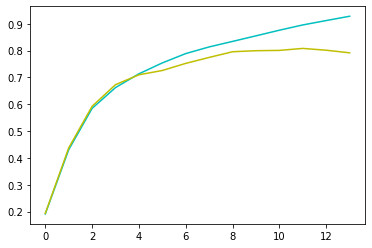

In [895]:
# Hyperparameter tuning for Decision tree Regression
# Find max depth
max_depth_hyp_tuning_train = []
max_depth_hyp_tuning_valid = []
max_depth = 0

for max_d in range(1, 15):
    model = tree.DecisionTreeRegressor(max_depth=max_d, random_state=42)
    model.fit(X_train, y_train)
    max_depth_hyp_tuning_train.append(model.score(X_train, y_train))
    max_depth_hyp_tuning_valid.append(model.score(X_valid, y_valid))

diff_train_valid = [train - valid for (train, valid) in zip(max_depth_hyp_tuning_train, max_depth_hyp_tuning_valid)]
plt.plot(max_depth_hyp_tuning_train, 'c')
plt.plot(max_depth_hyp_tuning_valid, 'y')
plt.show()
for index, score_diff in enumerate(diff_train_valid):
    if score_diff > 0:
        max_depth = index + 1
        break

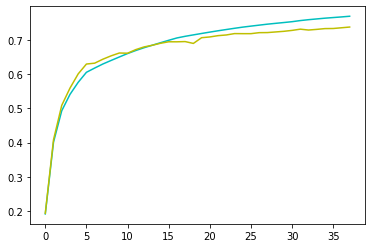

In [896]:
# Find max leaf_nodes
max_nodes_hyp_tuning_train = []
max_nodes_hyp_tuning_valid = []
max_nodes = 0

for max_n in range(2, 40):
    model = tree.DecisionTreeRegressor(max_leaf_nodes=max_n, random_state=42)
    model.fit(X_train, y_train)
    max_nodes_hyp_tuning_train.append(model.score(X_train, y_train))
    max_nodes_hyp_tuning_valid.append(model.score(X_valid, y_valid))

diff_train_valid = [train - valid for (train, valid) in zip(max_nodes_hyp_tuning_train, max_nodes_hyp_tuning_valid)]
plt.plot(max_nodes_hyp_tuning_train, 'c')
plt.plot(max_nodes_hyp_tuning_valid, 'y')
plt.show()
for index, score_diff in enumerate(diff_train_valid):
    if score_diff > 0:
        max_nodes = index + 2
        break

In [897]:
# Create Decision Tree Regressor model
dt_regressor = tree.DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes= max_nodes)

# Fit the model to the training data
dt_regressor.fit(X_train, y_train)

# Predict on test data
y_pred = dt_regressor.predict(X_test)

# Calculate performance metrics
dt_regressor.score(X_test, y_test)


0.6882492369539779

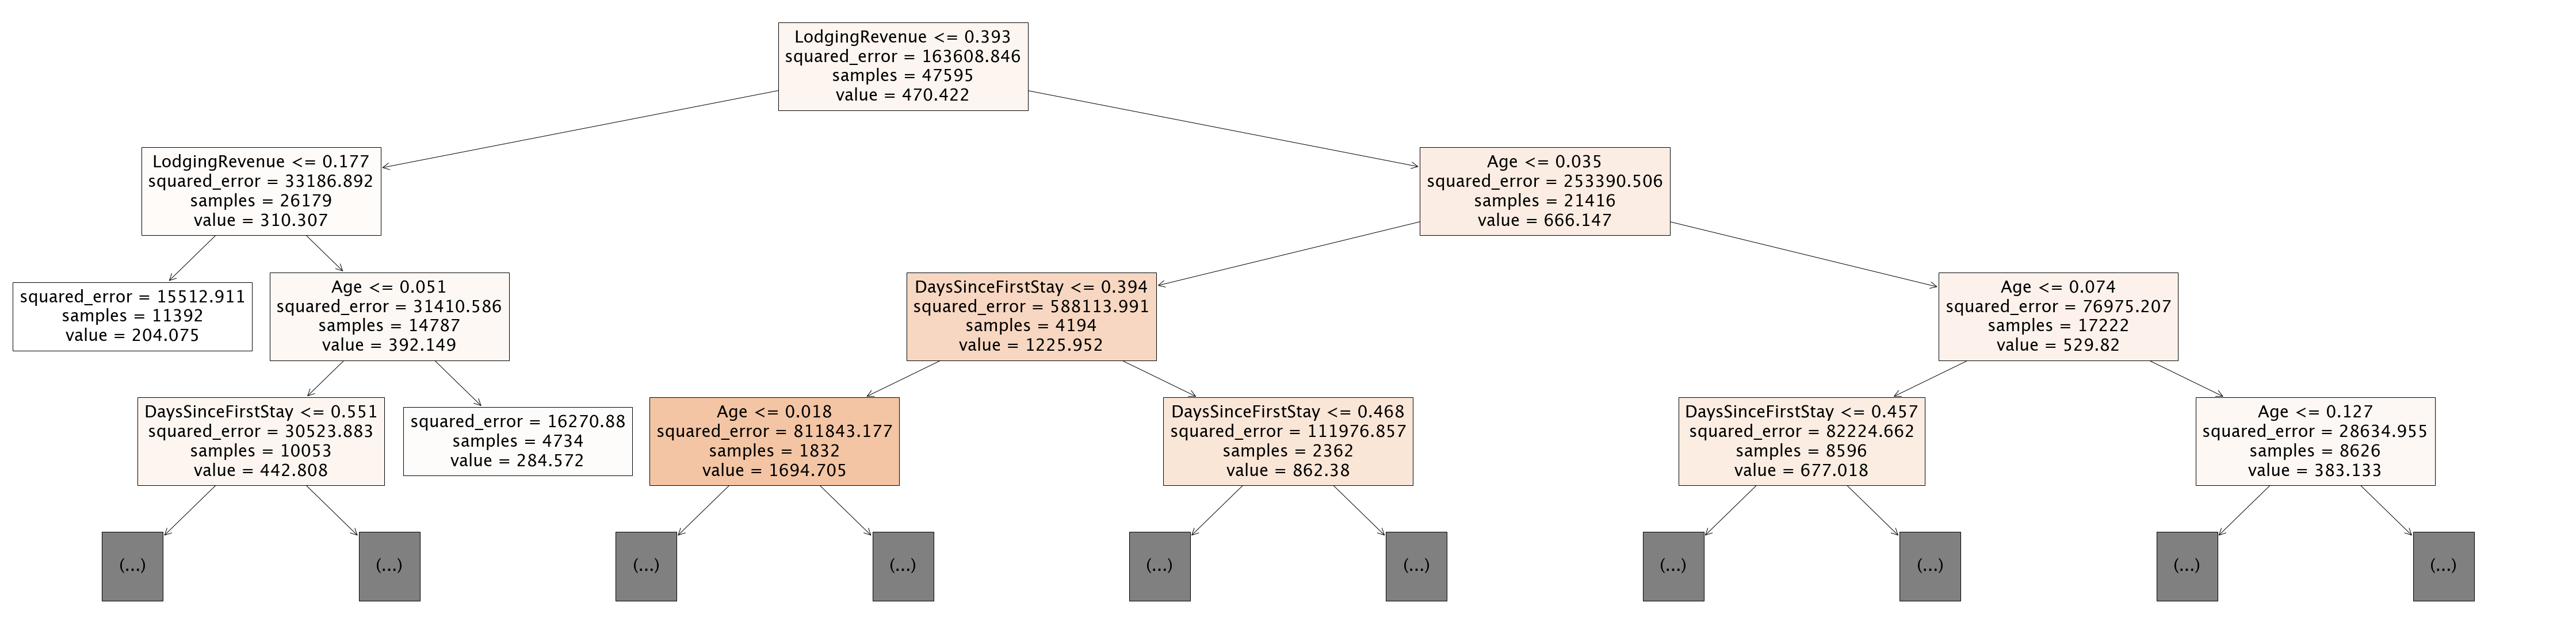

In [898]:
# Plot decision tree
plt.figure(figsize =(80,20))
plot_tree(dt_regressor, feature_names=X_train.columns, max_depth=3, filled=True);

### Calculating estimated Revenue in Next Period

In [899]:
# Predict total revenue per room
pred_rev = dt_regressor.predict(newcust_df[selected_features_df.columns])
newcust_df["TotalRevenuePerRoom_Pred"] = pred_rev 

In [900]:
# Assuming everyone just booked 1 room, find total revenue for that month
sum_pred_revenue = newcust_df['TotalRevenuePerRoom_Pred'].sum()
sum_pred_revenue

46023.716267585674

Other things we can consider: 
Doing PCA? But need to find a reason to do it? 